# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

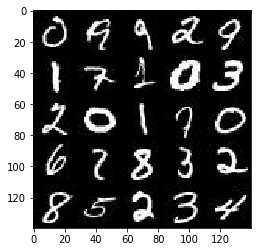

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

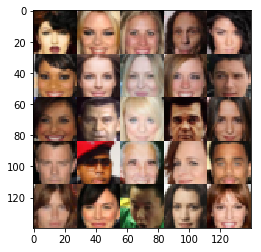

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "input_real")
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")
    return input_real, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, training=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not training):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
#         print("x1", x1.shape)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
#         print("x2", x2.shape)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
#         print("x3", x3.shape)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha2=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * alpha2))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     saver = tf.train.Saver()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                #rescale to [-1, 1]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.7042... Generator Loss: 6.7194
Epoch 1/2... Batch 20... Discriminator Loss: 0.7975... Generator Loss: 3.7041
Epoch 1/2... Batch 30... Discriminator Loss: 0.8495... Generator Loss: 1.8279
Epoch 1/2... Batch 40... Discriminator Loss: 0.5703... Generator Loss: 3.7351
Epoch 1/2... Batch 50... Discriminator Loss: 0.3509... Generator Loss: 5.6831
Epoch 1/2... Batch 60... Discriminator Loss: 0.3467... Generator Loss: 5.4529
Epoch 1/2... Batch 70... Discriminator Loss: 0.3544... Generator Loss: 4.6471
Epoch 1/2... Batch 80... Discriminator Loss: 0.7401... Generator Loss: 1.4059
Epoch 1/2... Batch 90... Discriminator Loss: 0.4051... Generator Loss: 3.8993
Epoch 1/2... Batch 100... Discriminator Loss: 2.2070... Generator Loss: 3.1765


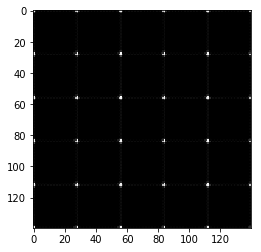

Epoch 1/2... Batch 110... Discriminator Loss: 1.1862... Generator Loss: 0.8495
Epoch 1/2... Batch 120... Discriminator Loss: 1.3179... Generator Loss: 0.7525
Epoch 1/2... Batch 130... Discriminator Loss: 1.2507... Generator Loss: 0.9265
Epoch 1/2... Batch 140... Discriminator Loss: 1.6515... Generator Loss: 2.0352
Epoch 1/2... Batch 150... Discriminator Loss: 1.8958... Generator Loss: 0.3115
Epoch 1/2... Batch 160... Discriminator Loss: 1.1297... Generator Loss: 0.7801
Epoch 1/2... Batch 170... Discriminator Loss: 1.2363... Generator Loss: 0.7216
Epoch 1/2... Batch 180... Discriminator Loss: 1.0919... Generator Loss: 1.3591
Epoch 1/2... Batch 190... Discriminator Loss: 1.3389... Generator Loss: 0.5633
Epoch 1/2... Batch 200... Discriminator Loss: 1.0793... Generator Loss: 1.5582


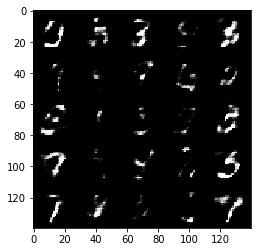

Epoch 1/2... Batch 210... Discriminator Loss: 0.5064... Generator Loss: 2.5202
Epoch 1/2... Batch 220... Discriminator Loss: 2.1194... Generator Loss: 0.2689
Epoch 1/2... Batch 230... Discriminator Loss: 1.5739... Generator Loss: 0.5072
Epoch 1/2... Batch 240... Discriminator Loss: 0.9695... Generator Loss: 1.0352
Epoch 1/2... Batch 250... Discriminator Loss: 0.9586... Generator Loss: 2.2422
Epoch 1/2... Batch 260... Discriminator Loss: 0.8521... Generator Loss: 1.6197
Epoch 1/2... Batch 270... Discriminator Loss: 1.8069... Generator Loss: 0.3977
Epoch 1/2... Batch 280... Discriminator Loss: 1.0174... Generator Loss: 1.9757
Epoch 1/2... Batch 290... Discriminator Loss: 0.9642... Generator Loss: 1.1174
Epoch 1/2... Batch 300... Discriminator Loss: 1.2866... Generator Loss: 0.6535


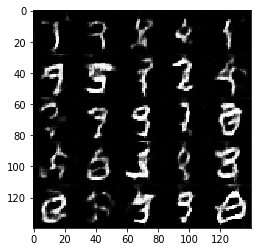

Epoch 1/2... Batch 310... Discriminator Loss: 1.1944... Generator Loss: 0.9973
Epoch 1/2... Batch 320... Discriminator Loss: 1.1091... Generator Loss: 0.9787
Epoch 1/2... Batch 330... Discriminator Loss: 1.0981... Generator Loss: 0.9888
Epoch 1/2... Batch 340... Discriminator Loss: 1.1902... Generator Loss: 0.7578
Epoch 1/2... Batch 350... Discriminator Loss: 1.2377... Generator Loss: 1.4559
Epoch 1/2... Batch 360... Discriminator Loss: 1.2742... Generator Loss: 1.1731
Epoch 1/2... Batch 370... Discriminator Loss: 1.1359... Generator Loss: 0.9681
Epoch 1/2... Batch 380... Discriminator Loss: 1.1875... Generator Loss: 0.7206
Epoch 1/2... Batch 390... Discriminator Loss: 1.3769... Generator Loss: 0.9791
Epoch 1/2... Batch 400... Discriminator Loss: 1.2260... Generator Loss: 1.0584


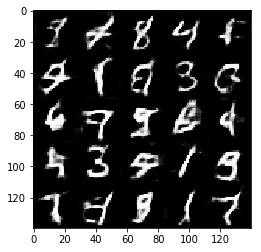

Epoch 1/2... Batch 410... Discriminator Loss: 1.4249... Generator Loss: 0.5933
Epoch 1/2... Batch 420... Discriminator Loss: 1.2810... Generator Loss: 1.3454
Epoch 1/2... Batch 430... Discriminator Loss: 1.1697... Generator Loss: 1.2759
Epoch 1/2... Batch 440... Discriminator Loss: 1.5461... Generator Loss: 0.5844
Epoch 1/2... Batch 450... Discriminator Loss: 1.2381... Generator Loss: 0.8821
Epoch 1/2... Batch 460... Discriminator Loss: 1.3859... Generator Loss: 0.6211
Epoch 1/2... Batch 470... Discriminator Loss: 1.0942... Generator Loss: 1.2663
Epoch 1/2... Batch 480... Discriminator Loss: 1.3746... Generator Loss: 0.5943
Epoch 1/2... Batch 490... Discriminator Loss: 1.4802... Generator Loss: 0.5900
Epoch 1/2... Batch 500... Discriminator Loss: 1.2338... Generator Loss: 0.7076


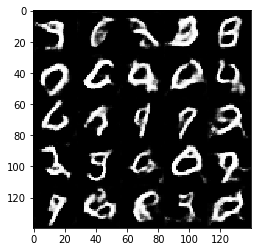

Epoch 1/2... Batch 510... Discriminator Loss: 1.2683... Generator Loss: 0.8977
Epoch 1/2... Batch 520... Discriminator Loss: 1.2758... Generator Loss: 0.9947
Epoch 1/2... Batch 530... Discriminator Loss: 1.1738... Generator Loss: 1.4870
Epoch 1/2... Batch 540... Discriminator Loss: 1.0526... Generator Loss: 1.1214
Epoch 1/2... Batch 550... Discriminator Loss: 1.2978... Generator Loss: 0.6069
Epoch 1/2... Batch 560... Discriminator Loss: 1.0199... Generator Loss: 0.9472
Epoch 1/2... Batch 570... Discriminator Loss: 1.1587... Generator Loss: 1.1699
Epoch 1/2... Batch 580... Discriminator Loss: 1.3304... Generator Loss: 0.6729
Epoch 1/2... Batch 590... Discriminator Loss: 1.1418... Generator Loss: 1.1646
Epoch 1/2... Batch 600... Discriminator Loss: 1.5001... Generator Loss: 0.5092


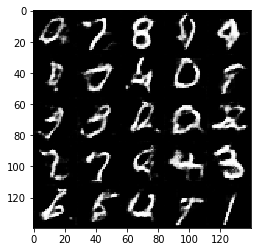

Epoch 1/2... Batch 610... Discriminator Loss: 1.1238... Generator Loss: 1.0621
Epoch 1/2... Batch 620... Discriminator Loss: 1.1409... Generator Loss: 0.7713
Epoch 1/2... Batch 630... Discriminator Loss: 1.2343... Generator Loss: 0.7086
Epoch 1/2... Batch 640... Discriminator Loss: 1.3688... Generator Loss: 0.5551
Epoch 1/2... Batch 650... Discriminator Loss: 1.2297... Generator Loss: 0.7656
Epoch 1/2... Batch 660... Discriminator Loss: 1.1728... Generator Loss: 0.9467
Epoch 1/2... Batch 670... Discriminator Loss: 1.1871... Generator Loss: 1.3876
Epoch 1/2... Batch 680... Discriminator Loss: 1.4491... Generator Loss: 0.4958
Epoch 1/2... Batch 690... Discriminator Loss: 1.1290... Generator Loss: 0.9677
Epoch 1/2... Batch 700... Discriminator Loss: 1.0927... Generator Loss: 1.7640


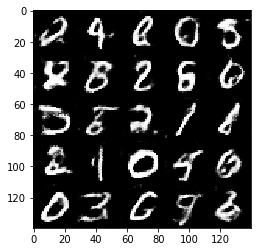

Epoch 1/2... Batch 710... Discriminator Loss: 1.1397... Generator Loss: 1.1611
Epoch 1/2... Batch 720... Discriminator Loss: 0.9826... Generator Loss: 1.2865
Epoch 1/2... Batch 730... Discriminator Loss: 1.3304... Generator Loss: 0.6490
Epoch 1/2... Batch 740... Discriminator Loss: 1.4260... Generator Loss: 0.6028
Epoch 1/2... Batch 750... Discriminator Loss: 1.0614... Generator Loss: 1.0102
Epoch 1/2... Batch 760... Discriminator Loss: 1.0964... Generator Loss: 0.7795
Epoch 1/2... Batch 770... Discriminator Loss: 1.2507... Generator Loss: 0.6953
Epoch 1/2... Batch 780... Discriminator Loss: 1.3862... Generator Loss: 0.5173
Epoch 1/2... Batch 790... Discriminator Loss: 0.9577... Generator Loss: 1.1418
Epoch 1/2... Batch 800... Discriminator Loss: 1.2949... Generator Loss: 0.6373


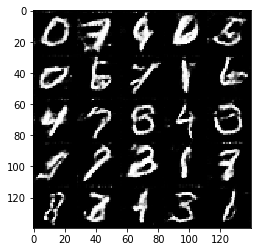

Epoch 1/2... Batch 810... Discriminator Loss: 1.2038... Generator Loss: 0.8275
Epoch 1/2... Batch 820... Discriminator Loss: 1.1058... Generator Loss: 0.9898
Epoch 1/2... Batch 830... Discriminator Loss: 1.5314... Generator Loss: 0.4392
Epoch 1/2... Batch 840... Discriminator Loss: 1.1710... Generator Loss: 1.1174
Epoch 1/2... Batch 850... Discriminator Loss: 1.0256... Generator Loss: 1.1040
Epoch 1/2... Batch 860... Discriminator Loss: 1.5113... Generator Loss: 2.6267
Epoch 1/2... Batch 870... Discriminator Loss: 1.0245... Generator Loss: 1.4262
Epoch 1/2... Batch 880... Discriminator Loss: 1.1731... Generator Loss: 0.7780
Epoch 1/2... Batch 890... Discriminator Loss: 1.1285... Generator Loss: 0.8026
Epoch 1/2... Batch 900... Discriminator Loss: 1.6037... Generator Loss: 0.4074


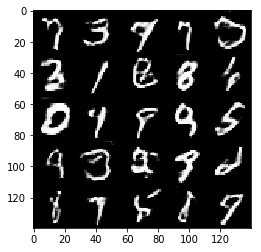

Epoch 1/2... Batch 910... Discriminator Loss: 1.3960... Generator Loss: 0.5402
Epoch 1/2... Batch 920... Discriminator Loss: 1.2804... Generator Loss: 0.7185
Epoch 1/2... Batch 930... Discriminator Loss: 1.0148... Generator Loss: 1.2577
Epoch 1/2... Batch 940... Discriminator Loss: 1.2934... Generator Loss: 1.2019
Epoch 1/2... Batch 950... Discriminator Loss: 1.0581... Generator Loss: 0.8846
Epoch 1/2... Batch 960... Discriminator Loss: 1.0668... Generator Loss: 0.9864
Epoch 1/2... Batch 970... Discriminator Loss: 1.0532... Generator Loss: 1.2351
Epoch 1/2... Batch 980... Discriminator Loss: 1.0944... Generator Loss: 0.8253
Epoch 1/2... Batch 990... Discriminator Loss: 1.3053... Generator Loss: 0.6128
Epoch 1/2... Batch 1000... Discriminator Loss: 1.1507... Generator Loss: 0.7417


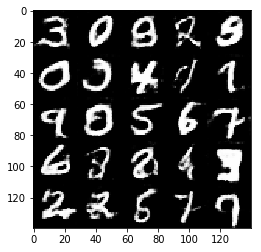

Epoch 1/2... Batch 1010... Discriminator Loss: 1.2705... Generator Loss: 0.7653
Epoch 1/2... Batch 1020... Discriminator Loss: 1.3803... Generator Loss: 0.5470
Epoch 1/2... Batch 1030... Discriminator Loss: 1.5158... Generator Loss: 0.4432
Epoch 1/2... Batch 1040... Discriminator Loss: 1.1350... Generator Loss: 0.8315
Epoch 1/2... Batch 1050... Discriminator Loss: 1.0309... Generator Loss: 1.3209
Epoch 1/2... Batch 1060... Discriminator Loss: 1.4070... Generator Loss: 0.5366
Epoch 1/2... Batch 1070... Discriminator Loss: 1.1718... Generator Loss: 0.8883
Epoch 1/2... Batch 1080... Discriminator Loss: 0.9923... Generator Loss: 0.9924
Epoch 1/2... Batch 1090... Discriminator Loss: 0.9662... Generator Loss: 1.2228
Epoch 1/2... Batch 1100... Discriminator Loss: 1.3116... Generator Loss: 0.6624


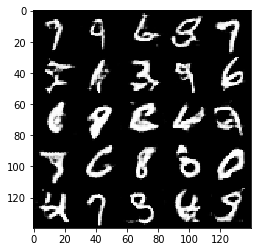

Epoch 1/2... Batch 1110... Discriminator Loss: 1.1173... Generator Loss: 1.4616
Epoch 1/2... Batch 1120... Discriminator Loss: 1.4083... Generator Loss: 2.1322
Epoch 1/2... Batch 1130... Discriminator Loss: 1.2198... Generator Loss: 0.6888
Epoch 1/2... Batch 1140... Discriminator Loss: 1.0073... Generator Loss: 0.8661
Epoch 1/2... Batch 1150... Discriminator Loss: 1.2180... Generator Loss: 0.6992
Epoch 1/2... Batch 1160... Discriminator Loss: 0.8436... Generator Loss: 1.4522
Epoch 1/2... Batch 1170... Discriminator Loss: 1.0916... Generator Loss: 1.7102
Epoch 1/2... Batch 1180... Discriminator Loss: 1.6135... Generator Loss: 0.4733
Epoch 1/2... Batch 1190... Discriminator Loss: 1.6029... Generator Loss: 0.4689
Epoch 1/2... Batch 1200... Discriminator Loss: 1.1109... Generator Loss: 0.7919


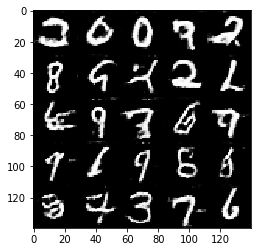

Epoch 1/2... Batch 1210... Discriminator Loss: 1.7330... Generator Loss: 0.3186
Epoch 1/2... Batch 1220... Discriminator Loss: 1.3366... Generator Loss: 0.6519
Epoch 1/2... Batch 1230... Discriminator Loss: 0.8260... Generator Loss: 1.2778
Epoch 1/2... Batch 1240... Discriminator Loss: 1.1585... Generator Loss: 2.1503
Epoch 1/2... Batch 1250... Discriminator Loss: 1.5152... Generator Loss: 0.4673
Epoch 1/2... Batch 1260... Discriminator Loss: 1.6961... Generator Loss: 0.3567
Epoch 1/2... Batch 1270... Discriminator Loss: 0.8851... Generator Loss: 1.4928
Epoch 1/2... Batch 1280... Discriminator Loss: 0.9854... Generator Loss: 1.2486
Epoch 1/2... Batch 1290... Discriminator Loss: 1.8694... Generator Loss: 0.3104
Epoch 1/2... Batch 1300... Discriminator Loss: 1.0557... Generator Loss: 1.4076


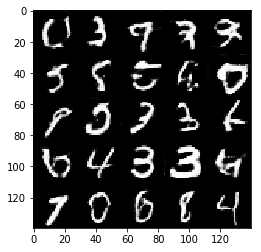

Epoch 1/2... Batch 1310... Discriminator Loss: 0.8223... Generator Loss: 1.6056
Epoch 1/2... Batch 1320... Discriminator Loss: 1.4806... Generator Loss: 0.5816
Epoch 1/2... Batch 1330... Discriminator Loss: 1.0954... Generator Loss: 0.8918
Epoch 1/2... Batch 1340... Discriminator Loss: 1.0066... Generator Loss: 1.0409
Epoch 1/2... Batch 1350... Discriminator Loss: 1.5385... Generator Loss: 0.5452
Epoch 1/2... Batch 1360... Discriminator Loss: 1.1714... Generator Loss: 1.1526
Epoch 1/2... Batch 1370... Discriminator Loss: 1.2514... Generator Loss: 0.6456
Epoch 1/2... Batch 1380... Discriminator Loss: 1.3767... Generator Loss: 0.6692
Epoch 1/2... Batch 1390... Discriminator Loss: 1.2390... Generator Loss: 0.7082
Epoch 1/2... Batch 1400... Discriminator Loss: 1.0378... Generator Loss: 1.3991


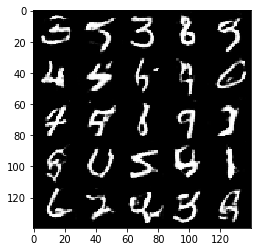

Epoch 1/2... Batch 1410... Discriminator Loss: 1.1986... Generator Loss: 0.6868
Epoch 1/2... Batch 1420... Discriminator Loss: 0.8573... Generator Loss: 1.2799
Epoch 1/2... Batch 1430... Discriminator Loss: 1.4601... Generator Loss: 0.4994
Epoch 1/2... Batch 1440... Discriminator Loss: 0.9846... Generator Loss: 0.9189
Epoch 1/2... Batch 1450... Discriminator Loss: 1.2009... Generator Loss: 0.7046
Epoch 1/2... Batch 1460... Discriminator Loss: 0.9568... Generator Loss: 1.1481
Epoch 1/2... Batch 1470... Discriminator Loss: 0.9710... Generator Loss: 1.9352
Epoch 1/2... Batch 1480... Discriminator Loss: 0.9478... Generator Loss: 1.0278
Epoch 1/2... Batch 1490... Discriminator Loss: 0.8151... Generator Loss: 2.0256
Epoch 1/2... Batch 1500... Discriminator Loss: 1.0132... Generator Loss: 1.5491


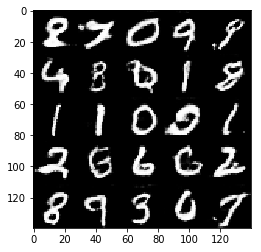

Epoch 1/2... Batch 1510... Discriminator Loss: 1.0984... Generator Loss: 0.8646
Epoch 1/2... Batch 1520... Discriminator Loss: 1.1531... Generator Loss: 0.7130
Epoch 1/2... Batch 1530... Discriminator Loss: 1.2489... Generator Loss: 0.6077
Epoch 1/2... Batch 1540... Discriminator Loss: 1.6615... Generator Loss: 0.4492
Epoch 1/2... Batch 1550... Discriminator Loss: 0.9583... Generator Loss: 1.3583
Epoch 1/2... Batch 1560... Discriminator Loss: 1.0827... Generator Loss: 1.6283
Epoch 1/2... Batch 1570... Discriminator Loss: 0.9740... Generator Loss: 1.6164
Epoch 1/2... Batch 1580... Discriminator Loss: 0.9278... Generator Loss: 1.6930
Epoch 1/2... Batch 1590... Discriminator Loss: 1.4629... Generator Loss: 0.5758
Epoch 1/2... Batch 1600... Discriminator Loss: 1.7500... Generator Loss: 0.3852


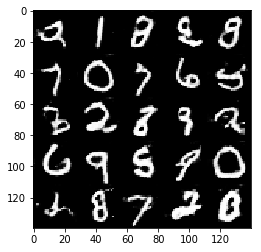

Epoch 1/2... Batch 1610... Discriminator Loss: 1.1056... Generator Loss: 0.8408
Epoch 1/2... Batch 1620... Discriminator Loss: 1.0259... Generator Loss: 2.1441
Epoch 1/2... Batch 1630... Discriminator Loss: 1.4104... Generator Loss: 1.6356
Epoch 1/2... Batch 1640... Discriminator Loss: 1.3136... Generator Loss: 0.5673
Epoch 1/2... Batch 1650... Discriminator Loss: 1.1038... Generator Loss: 2.1329
Epoch 1/2... Batch 1660... Discriminator Loss: 1.5109... Generator Loss: 0.5144
Epoch 1/2... Batch 1670... Discriminator Loss: 0.9304... Generator Loss: 1.1182
Epoch 1/2... Batch 1680... Discriminator Loss: 1.4560... Generator Loss: 0.6021
Epoch 1/2... Batch 1690... Discriminator Loss: 1.3099... Generator Loss: 0.7272
Epoch 1/2... Batch 1700... Discriminator Loss: 1.2555... Generator Loss: 0.6667


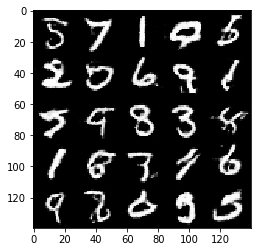

Epoch 1/2... Batch 1710... Discriminator Loss: 1.3701... Generator Loss: 0.5953
Epoch 1/2... Batch 1720... Discriminator Loss: 0.7413... Generator Loss: 1.5602
Epoch 1/2... Batch 1730... Discriminator Loss: 0.8919... Generator Loss: 1.0660
Epoch 1/2... Batch 1740... Discriminator Loss: 1.3125... Generator Loss: 2.2292
Epoch 1/2... Batch 1750... Discriminator Loss: 1.1116... Generator Loss: 1.2182
Epoch 1/2... Batch 1760... Discriminator Loss: 0.8573... Generator Loss: 1.2095
Epoch 1/2... Batch 1770... Discriminator Loss: 1.6027... Generator Loss: 0.4451
Epoch 1/2... Batch 1780... Discriminator Loss: 0.7983... Generator Loss: 1.5050
Epoch 1/2... Batch 1790... Discriminator Loss: 1.1535... Generator Loss: 0.9350
Epoch 1/2... Batch 1800... Discriminator Loss: 1.0289... Generator Loss: 0.8364


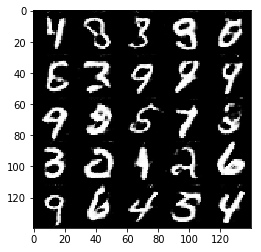

Epoch 1/2... Batch 1810... Discriminator Loss: 1.0595... Generator Loss: 1.0636
Epoch 1/2... Batch 1820... Discriminator Loss: 1.8333... Generator Loss: 0.3626
Epoch 1/2... Batch 1830... Discriminator Loss: 0.9021... Generator Loss: 1.2292
Epoch 1/2... Batch 1840... Discriminator Loss: 0.7638... Generator Loss: 1.5643
Epoch 1/2... Batch 1850... Discriminator Loss: 1.6160... Generator Loss: 0.4604
Epoch 1/2... Batch 1860... Discriminator Loss: 0.8341... Generator Loss: 1.0924
Epoch 1/2... Batch 1870... Discriminator Loss: 1.0521... Generator Loss: 0.8931
Epoch 2/2... Batch 10... Discriminator Loss: 1.1010... Generator Loss: 0.9276
Epoch 2/2... Batch 20... Discriminator Loss: 0.9881... Generator Loss: 0.9742
Epoch 2/2... Batch 30... Discriminator Loss: 1.3865... Generator Loss: 0.5332
Epoch 2/2... Batch 40... Discriminator Loss: 0.8746... Generator Loss: 1.1269
Epoch 2/2... Batch 50... Discriminator Loss: 0.8753... Generator Loss: 1.1578
Epoch 2/2... Batch 60... Discriminator Loss: 0.967

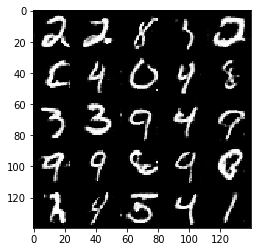

Epoch 2/2... Batch 110... Discriminator Loss: 1.3963... Generator Loss: 0.5605
Epoch 2/2... Batch 120... Discriminator Loss: 0.9538... Generator Loss: 1.0061
Epoch 2/2... Batch 130... Discriminator Loss: 0.9283... Generator Loss: 1.0096
Epoch 2/2... Batch 140... Discriminator Loss: 1.1203... Generator Loss: 0.7779
Epoch 2/2... Batch 150... Discriminator Loss: 1.2270... Generator Loss: 0.7013
Epoch 2/2... Batch 160... Discriminator Loss: 0.6201... Generator Loss: 1.6893
Epoch 2/2... Batch 170... Discriminator Loss: 0.7129... Generator Loss: 1.5615
Epoch 2/2... Batch 180... Discriminator Loss: 0.9181... Generator Loss: 1.1235
Epoch 2/2... Batch 190... Discriminator Loss: 0.7338... Generator Loss: 1.4897
Epoch 2/2... Batch 200... Discriminator Loss: 0.6316... Generator Loss: 1.8260


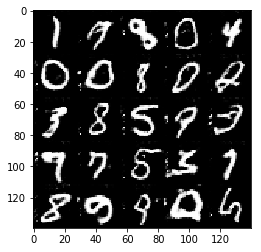

Epoch 2/2... Batch 210... Discriminator Loss: 1.0684... Generator Loss: 2.7165
Epoch 2/2... Batch 220... Discriminator Loss: 0.9000... Generator Loss: 1.3455
Epoch 2/2... Batch 230... Discriminator Loss: 0.7297... Generator Loss: 1.3498
Epoch 2/2... Batch 240... Discriminator Loss: 0.7679... Generator Loss: 1.3264
Epoch 2/2... Batch 250... Discriminator Loss: 0.7021... Generator Loss: 2.4916
Epoch 2/2... Batch 260... Discriminator Loss: 1.6749... Generator Loss: 0.4054
Epoch 2/2... Batch 270... Discriminator Loss: 0.8018... Generator Loss: 1.1627
Epoch 2/2... Batch 280... Discriminator Loss: 0.7393... Generator Loss: 2.3705
Epoch 2/2... Batch 290... Discriminator Loss: 1.0876... Generator Loss: 2.2774
Epoch 2/2... Batch 300... Discriminator Loss: 0.8449... Generator Loss: 1.3776


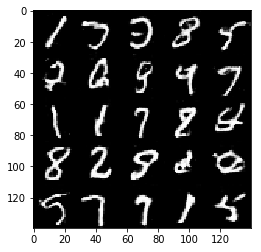

Epoch 2/2... Batch 310... Discriminator Loss: 1.5019... Generator Loss: 0.6944
Epoch 2/2... Batch 320... Discriminator Loss: 0.8894... Generator Loss: 1.3317
Epoch 2/2... Batch 330... Discriminator Loss: 0.7348... Generator Loss: 1.3888
Epoch 2/2... Batch 340... Discriminator Loss: 1.1351... Generator Loss: 0.8636
Epoch 2/2... Batch 350... Discriminator Loss: 0.8620... Generator Loss: 1.1169
Epoch 2/2... Batch 360... Discriminator Loss: 1.1767... Generator Loss: 0.7601
Epoch 2/2... Batch 370... Discriminator Loss: 1.2973... Generator Loss: 0.6460
Epoch 2/2... Batch 380... Discriminator Loss: 0.8594... Generator Loss: 1.2491
Epoch 2/2... Batch 390... Discriminator Loss: 0.9430... Generator Loss: 2.6842
Epoch 2/2... Batch 400... Discriminator Loss: 1.0861... Generator Loss: 0.8681


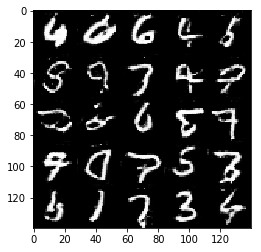

Epoch 2/2... Batch 410... Discriminator Loss: 1.5139... Generator Loss: 0.4976
Epoch 2/2... Batch 420... Discriminator Loss: 0.8080... Generator Loss: 1.3756
Epoch 2/2... Batch 430... Discriminator Loss: 1.1122... Generator Loss: 0.9098
Epoch 2/2... Batch 440... Discriminator Loss: 0.6044... Generator Loss: 1.8968
Epoch 2/2... Batch 450... Discriminator Loss: 0.7963... Generator Loss: 1.4144
Epoch 2/2... Batch 460... Discriminator Loss: 1.1838... Generator Loss: 0.7985
Epoch 2/2... Batch 470... Discriminator Loss: 1.7468... Generator Loss: 0.3613
Epoch 2/2... Batch 480... Discriminator Loss: 1.0710... Generator Loss: 0.8889
Epoch 2/2... Batch 490... Discriminator Loss: 0.7971... Generator Loss: 1.4671
Epoch 2/2... Batch 500... Discriminator Loss: 0.7476... Generator Loss: 1.4957


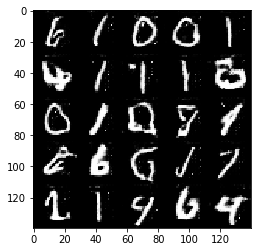

Epoch 2/2... Batch 510... Discriminator Loss: 0.7654... Generator Loss: 1.2989
Epoch 2/2... Batch 520... Discriminator Loss: 1.1372... Generator Loss: 0.7863
Epoch 2/2... Batch 530... Discriminator Loss: 0.7837... Generator Loss: 1.3833
Epoch 2/2... Batch 540... Discriminator Loss: 2.0497... Generator Loss: 0.3376
Epoch 2/2... Batch 550... Discriminator Loss: 1.1155... Generator Loss: 0.8412
Epoch 2/2... Batch 560... Discriminator Loss: 1.1114... Generator Loss: 0.7537
Epoch 2/2... Batch 570... Discriminator Loss: 0.6965... Generator Loss: 1.6573
Epoch 2/2... Batch 580... Discriminator Loss: 0.8252... Generator Loss: 1.2670
Epoch 2/2... Batch 590... Discriminator Loss: 1.1881... Generator Loss: 0.7779
Epoch 2/2... Batch 600... Discriminator Loss: 0.6970... Generator Loss: 1.5645


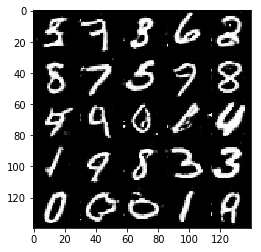

Epoch 2/2... Batch 610... Discriminator Loss: 1.1883... Generator Loss: 0.8413
Epoch 2/2... Batch 620... Discriminator Loss: 0.8209... Generator Loss: 1.2421
Epoch 2/2... Batch 630... Discriminator Loss: 0.7509... Generator Loss: 1.4554
Epoch 2/2... Batch 640... Discriminator Loss: 1.1361... Generator Loss: 0.9739
Epoch 2/2... Batch 650... Discriminator Loss: 1.2289... Generator Loss: 0.8534
Epoch 2/2... Batch 660... Discriminator Loss: 0.6145... Generator Loss: 1.7823
Epoch 2/2... Batch 670... Discriminator Loss: 1.6988... Generator Loss: 3.9867
Epoch 2/2... Batch 680... Discriminator Loss: 1.4381... Generator Loss: 0.5859
Epoch 2/2... Batch 690... Discriminator Loss: 1.4311... Generator Loss: 2.9763
Epoch 2/2... Batch 700... Discriminator Loss: 0.6468... Generator Loss: 2.0437


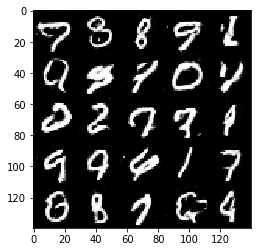

Epoch 2/2... Batch 710... Discriminator Loss: 1.0113... Generator Loss: 0.9132
Epoch 2/2... Batch 720... Discriminator Loss: 0.6485... Generator Loss: 1.7205
Epoch 2/2... Batch 730... Discriminator Loss: 0.6672... Generator Loss: 1.6767
Epoch 2/2... Batch 740... Discriminator Loss: 1.1553... Generator Loss: 0.8729
Epoch 2/2... Batch 750... Discriminator Loss: 0.8129... Generator Loss: 1.9952
Epoch 2/2... Batch 760... Discriminator Loss: 0.5171... Generator Loss: 2.2056
Epoch 2/2... Batch 770... Discriminator Loss: 2.1237... Generator Loss: 0.4422
Epoch 2/2... Batch 780... Discriminator Loss: 0.8785... Generator Loss: 2.3964
Epoch 2/2... Batch 790... Discriminator Loss: 0.6347... Generator Loss: 1.9112
Epoch 2/2... Batch 800... Discriminator Loss: 0.6216... Generator Loss: 1.7435


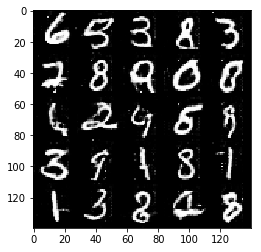

Epoch 2/2... Batch 810... Discriminator Loss: 1.2583... Generator Loss: 0.6533
Epoch 2/2... Batch 820... Discriminator Loss: 0.6132... Generator Loss: 1.8134
Epoch 2/2... Batch 830... Discriminator Loss: 0.8657... Generator Loss: 1.1722
Epoch 2/2... Batch 840... Discriminator Loss: 0.6466... Generator Loss: 1.9535
Epoch 2/2... Batch 850... Discriminator Loss: 0.6588... Generator Loss: 1.5562
Epoch 2/2... Batch 860... Discriminator Loss: 0.8096... Generator Loss: 1.4987
Epoch 2/2... Batch 870... Discriminator Loss: 1.2604... Generator Loss: 2.5606
Epoch 2/2... Batch 880... Discriminator Loss: 0.8728... Generator Loss: 1.8948
Epoch 2/2... Batch 890... Discriminator Loss: 0.8944... Generator Loss: 1.0771
Epoch 2/2... Batch 900... Discriminator Loss: 0.9692... Generator Loss: 1.0015


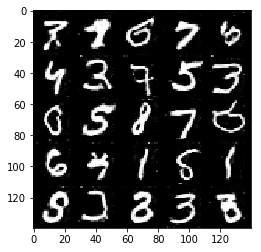

Epoch 2/2... Batch 910... Discriminator Loss: 1.2979... Generator Loss: 0.6290
Epoch 2/2... Batch 920... Discriminator Loss: 1.5028... Generator Loss: 0.5087
Epoch 2/2... Batch 930... Discriminator Loss: 1.9470... Generator Loss: 0.2920
Epoch 2/2... Batch 940... Discriminator Loss: 0.9762... Generator Loss: 0.9273
Epoch 2/2... Batch 950... Discriminator Loss: 0.9637... Generator Loss: 1.0238
Epoch 2/2... Batch 960... Discriminator Loss: 0.7357... Generator Loss: 1.5891
Epoch 2/2... Batch 970... Discriminator Loss: 0.6746... Generator Loss: 1.5578
Epoch 2/2... Batch 980... Discriminator Loss: 0.6960... Generator Loss: 1.5759
Epoch 2/2... Batch 990... Discriminator Loss: 0.8213... Generator Loss: 1.2264
Epoch 2/2... Batch 1000... Discriminator Loss: 0.6882... Generator Loss: 1.4605


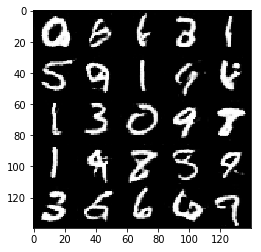

Epoch 2/2... Batch 1010... Discriminator Loss: 0.8125... Generator Loss: 1.3108
Epoch 2/2... Batch 1020... Discriminator Loss: 1.1385... Generator Loss: 0.7260
Epoch 2/2... Batch 1030... Discriminator Loss: 1.3563... Generator Loss: 0.6497
Epoch 2/2... Batch 1040... Discriminator Loss: 0.7701... Generator Loss: 1.8579
Epoch 2/2... Batch 1050... Discriminator Loss: 0.6388... Generator Loss: 1.7295
Epoch 2/2... Batch 1060... Discriminator Loss: 0.7744... Generator Loss: 2.1530
Epoch 2/2... Batch 1070... Discriminator Loss: 0.7557... Generator Loss: 1.5325
Epoch 2/2... Batch 1080... Discriminator Loss: 0.9337... Generator Loss: 1.3660
Epoch 2/2... Batch 1090... Discriminator Loss: 0.6449... Generator Loss: 1.7550
Epoch 2/2... Batch 1100... Discriminator Loss: 0.7459... Generator Loss: 1.4067


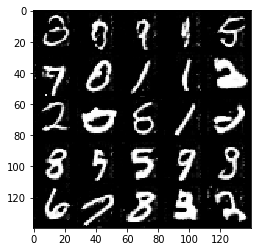

Epoch 2/2... Batch 1110... Discriminator Loss: 0.7857... Generator Loss: 2.1425
Epoch 2/2... Batch 1120... Discriminator Loss: 0.7606... Generator Loss: 1.8758
Epoch 2/2... Batch 1130... Discriminator Loss: 0.8202... Generator Loss: 1.2263
Epoch 2/2... Batch 1140... Discriminator Loss: 0.8685... Generator Loss: 1.1366
Epoch 2/2... Batch 1150... Discriminator Loss: 0.9875... Generator Loss: 1.1472
Epoch 2/2... Batch 1160... Discriminator Loss: 1.0318... Generator Loss: 2.3975
Epoch 2/2... Batch 1170... Discriminator Loss: 1.0536... Generator Loss: 1.1414
Epoch 2/2... Batch 1180... Discriminator Loss: 0.5658... Generator Loss: 2.1802
Epoch 2/2... Batch 1190... Discriminator Loss: 0.8838... Generator Loss: 1.1279
Epoch 2/2... Batch 1200... Discriminator Loss: 0.8147... Generator Loss: 1.4768


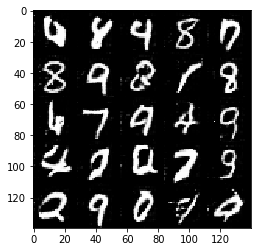

Epoch 2/2... Batch 1210... Discriminator Loss: 1.9786... Generator Loss: 0.3917
Epoch 2/2... Batch 1220... Discriminator Loss: 0.8269... Generator Loss: 1.2901
Epoch 2/2... Batch 1230... Discriminator Loss: 0.7475... Generator Loss: 3.2045
Epoch 2/2... Batch 1240... Discriminator Loss: 0.7052... Generator Loss: 1.9231
Epoch 2/2... Batch 1250... Discriminator Loss: 4.7461... Generator Loss: 0.0612
Epoch 2/2... Batch 1260... Discriminator Loss: 1.2338... Generator Loss: 0.7291
Epoch 2/2... Batch 1270... Discriminator Loss: 0.9614... Generator Loss: 0.9482
Epoch 2/2... Batch 1280... Discriminator Loss: 1.1245... Generator Loss: 0.7983
Epoch 2/2... Batch 1290... Discriminator Loss: 1.7911... Generator Loss: 0.3989
Epoch 2/2... Batch 1300... Discriminator Loss: 0.7694... Generator Loss: 1.3432


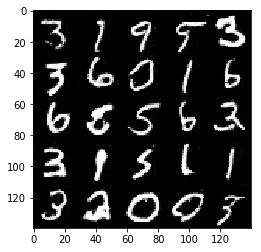

Epoch 2/2... Batch 1310... Discriminator Loss: 0.5320... Generator Loss: 2.1956
Epoch 2/2... Batch 1320... Discriminator Loss: 0.6209... Generator Loss: 1.6993
Epoch 2/2... Batch 1330... Discriminator Loss: 0.4928... Generator Loss: 2.3221
Epoch 2/2... Batch 1340... Discriminator Loss: 0.9133... Generator Loss: 1.2134
Epoch 2/2... Batch 1350... Discriminator Loss: 1.6997... Generator Loss: 0.4425
Epoch 2/2... Batch 1360... Discriminator Loss: 1.5712... Generator Loss: 0.5214
Epoch 2/2... Batch 1370... Discriminator Loss: 0.9182... Generator Loss: 1.1492
Epoch 2/2... Batch 1380... Discriminator Loss: 0.7516... Generator Loss: 1.3085
Epoch 2/2... Batch 1390... Discriminator Loss: 0.6062... Generator Loss: 2.2083
Epoch 2/2... Batch 1400... Discriminator Loss: 1.1522... Generator Loss: 0.8474


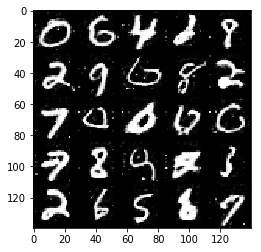

Epoch 2/2... Batch 1410... Discriminator Loss: 0.7170... Generator Loss: 1.5431
Epoch 2/2... Batch 1420... Discriminator Loss: 0.7587... Generator Loss: 1.5055
Epoch 2/2... Batch 1430... Discriminator Loss: 0.7716... Generator Loss: 1.3135
Epoch 2/2... Batch 1440... Discriminator Loss: 0.6793... Generator Loss: 1.6481
Epoch 2/2... Batch 1450... Discriminator Loss: 0.6461... Generator Loss: 1.7519
Epoch 2/2... Batch 1460... Discriminator Loss: 0.7520... Generator Loss: 1.8675
Epoch 2/2... Batch 1470... Discriminator Loss: 0.6512... Generator Loss: 1.7774
Epoch 2/2... Batch 1480... Discriminator Loss: 1.0283... Generator Loss: 0.9124
Epoch 2/2... Batch 1490... Discriminator Loss: 0.7722... Generator Loss: 1.6014
Epoch 2/2... Batch 1500... Discriminator Loss: 1.1724... Generator Loss: 0.8059


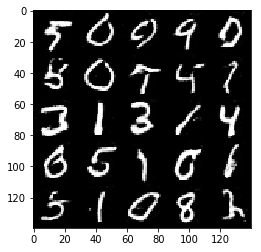

Epoch 2/2... Batch 1510... Discriminator Loss: 1.9358... Generator Loss: 0.4132
Epoch 2/2... Batch 1520... Discriminator Loss: 1.2087... Generator Loss: 0.8391
Epoch 2/2... Batch 1530... Discriminator Loss: 0.8917... Generator Loss: 1.1703
Epoch 2/2... Batch 1540... Discriminator Loss: 0.6531... Generator Loss: 1.8564
Epoch 2/2... Batch 1550... Discriminator Loss: 0.7299... Generator Loss: 1.4769
Epoch 2/2... Batch 1560... Discriminator Loss: 1.7481... Generator Loss: 2.6608
Epoch 2/2... Batch 1570... Discriminator Loss: 0.6350... Generator Loss: 2.1262
Epoch 2/2... Batch 1580... Discriminator Loss: 1.0267... Generator Loss: 0.9200
Epoch 2/2... Batch 1590... Discriminator Loss: 0.7758... Generator Loss: 1.4024
Epoch 2/2... Batch 1600... Discriminator Loss: 0.7512... Generator Loss: 1.3484


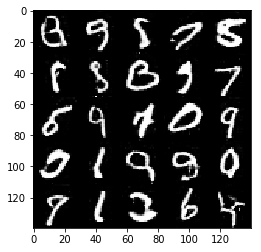

Epoch 2/2... Batch 1610... Discriminator Loss: 1.6408... Generator Loss: 0.4856
Epoch 2/2... Batch 1620... Discriminator Loss: 0.6032... Generator Loss: 2.0195
Epoch 2/2... Batch 1630... Discriminator Loss: 0.7645... Generator Loss: 1.4811
Epoch 2/2... Batch 1640... Discriminator Loss: 1.2693... Generator Loss: 0.8263
Epoch 2/2... Batch 1650... Discriminator Loss: 0.8997... Generator Loss: 1.5227
Epoch 2/2... Batch 1660... Discriminator Loss: 0.8794... Generator Loss: 1.3845
Epoch 2/2... Batch 1670... Discriminator Loss: 0.7870... Generator Loss: 1.2828
Epoch 2/2... Batch 1680... Discriminator Loss: 1.4321... Generator Loss: 0.5572
Epoch 2/2... Batch 1690... Discriminator Loss: 1.1361... Generator Loss: 0.7681
Epoch 2/2... Batch 1700... Discriminator Loss: 0.7607... Generator Loss: 1.5095


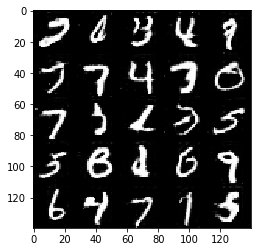

Epoch 2/2... Batch 1710... Discriminator Loss: 0.8707... Generator Loss: 1.1467
Epoch 2/2... Batch 1720... Discriminator Loss: 0.7310... Generator Loss: 1.3274
Epoch 2/2... Batch 1730... Discriminator Loss: 1.5336... Generator Loss: 0.4967
Epoch 2/2... Batch 1740... Discriminator Loss: 1.1346... Generator Loss: 0.7920
Epoch 2/2... Batch 1750... Discriminator Loss: 0.7673... Generator Loss: 1.3863
Epoch 2/2... Batch 1760... Discriminator Loss: 0.7586... Generator Loss: 1.5894
Epoch 2/2... Batch 1770... Discriminator Loss: 1.4619... Generator Loss: 0.5923
Epoch 2/2... Batch 1780... Discriminator Loss: 1.0427... Generator Loss: 1.0240
Epoch 2/2... Batch 1790... Discriminator Loss: 0.8963... Generator Loss: 1.0068
Epoch 2/2... Batch 1800... Discriminator Loss: 1.0627... Generator Loss: 0.8119


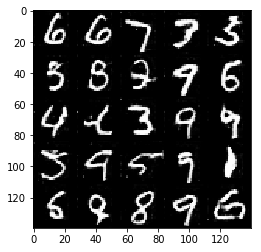

Epoch 2/2... Batch 1810... Discriminator Loss: 1.9343... Generator Loss: 0.3512
Epoch 2/2... Batch 1820... Discriminator Loss: 1.0639... Generator Loss: 0.8757
Epoch 2/2... Batch 1830... Discriminator Loss: 0.9454... Generator Loss: 1.0922
Epoch 2/2... Batch 1840... Discriminator Loss: 1.1126... Generator Loss: 0.7551
Epoch 2/2... Batch 1850... Discriminator Loss: 0.6989... Generator Loss: 1.6882
Epoch 2/2... Batch 1860... Discriminator Loss: 1.0134... Generator Loss: 0.9985
Epoch 2/2... Batch 1870... Discriminator Loss: 1.5418... Generator Loss: 0.6311


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.4723... Generator Loss: 3.1184
Epoch 1/1... Batch 20... Discriminator Loss: 2.7506... Generator Loss: 0.1646
Epoch 1/1... Batch 30... Discriminator Loss: 0.6317... Generator Loss: 1.9780
Epoch 1/1... Batch 40... Discriminator Loss: 1.6234... Generator Loss: 0.6627
Epoch 1/1... Batch 50... Discriminator Loss: 0.4774... Generator Loss: 3.3532
Epoch 1/1... Batch 60... Discriminator Loss: 0.3804... Generator Loss: 4.7053
Epoch 1/1... Batch 70... Discriminator Loss: 0.3747... Generator Loss: 4.4666
Epoch 1/1... Batch 80... Discriminator Loss: 0.3488... Generator Loss: 6.0619
Epoch 1/1... Batch 90... Discriminator Loss: 0.3464... Generator Loss: 6.2400
Epoch 1/1... Batch 100... Discriminator Loss: 0.3335... Generator Loss: 6.6992


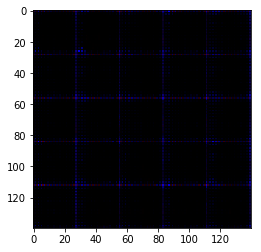

Epoch 1/1... Batch 110... Discriminator Loss: 0.3308... Generator Loss: 6.9733
Epoch 1/1... Batch 120... Discriminator Loss: 0.3291... Generator Loss: 7.1449
Epoch 1/1... Batch 130... Discriminator Loss: 0.3302... Generator Loss: 7.4018
Epoch 1/1... Batch 140... Discriminator Loss: 0.3376... Generator Loss: 7.0339
Epoch 1/1... Batch 150... Discriminator Loss: 0.3279... Generator Loss: 7.8144
Epoch 1/1... Batch 160... Discriminator Loss: 0.3275... Generator Loss: 7.6094
Epoch 1/1... Batch 170... Discriminator Loss: 0.3292... Generator Loss: 7.5780
Epoch 1/1... Batch 180... Discriminator Loss: 0.3294... Generator Loss: 7.6687
Epoch 1/1... Batch 190... Discriminator Loss: 0.3302... Generator Loss: 7.6361
Epoch 1/1... Batch 200... Discriminator Loss: 0.3266... Generator Loss: 8.1734


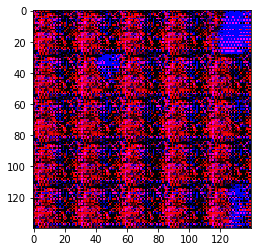

Epoch 1/1... Batch 210... Discriminator Loss: 0.3290... Generator Loss: 6.2319
Epoch 1/1... Batch 220... Discriminator Loss: 0.6177... Generator Loss: 2.4122
Epoch 1/1... Batch 230... Discriminator Loss: 0.3696... Generator Loss: 5.0608
Epoch 1/1... Batch 240... Discriminator Loss: 2.0433... Generator Loss: 8.3069
Epoch 1/1... Batch 250... Discriminator Loss: 0.6435... Generator Loss: 3.7563
Epoch 1/1... Batch 260... Discriminator Loss: 0.5832... Generator Loss: 2.3236
Epoch 1/1... Batch 270... Discriminator Loss: 0.4702... Generator Loss: 2.7730
Epoch 1/1... Batch 280... Discriminator Loss: 0.4468... Generator Loss: 2.7124
Epoch 1/1... Batch 290... Discriminator Loss: 1.4769... Generator Loss: 6.0202
Epoch 1/1... Batch 300... Discriminator Loss: 0.4322... Generator Loss: 3.3486


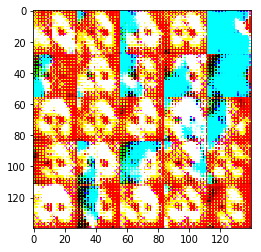

Epoch 1/1... Batch 310... Discriminator Loss: 0.3706... Generator Loss: 4.2220
Epoch 1/1... Batch 320... Discriminator Loss: 0.4094... Generator Loss: 2.9699
Epoch 1/1... Batch 330... Discriminator Loss: 0.3447... Generator Loss: 7.4514
Epoch 1/1... Batch 340... Discriminator Loss: 0.3419... Generator Loss: 5.6124
Epoch 1/1... Batch 350... Discriminator Loss: 0.3351... Generator Loss: 6.3895
Epoch 1/1... Batch 360... Discriminator Loss: 0.3340... Generator Loss: 5.5529
Epoch 1/1... Batch 370... Discriminator Loss: 0.3560... Generator Loss: 6.3999
Epoch 1/1... Batch 380... Discriminator Loss: 0.7544... Generator Loss: 4.7570
Epoch 1/1... Batch 390... Discriminator Loss: 1.2207... Generator Loss: 2.0117
Epoch 1/1... Batch 400... Discriminator Loss: 0.9207... Generator Loss: 3.1749


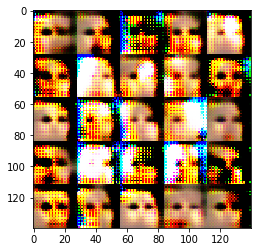

Epoch 1/1... Batch 410... Discriminator Loss: 1.6785... Generator Loss: 0.8167
Epoch 1/1... Batch 420... Discriminator Loss: 1.2930... Generator Loss: 0.9205
Epoch 1/1... Batch 430... Discriminator Loss: 1.6524... Generator Loss: 0.5541
Epoch 1/1... Batch 440... Discriminator Loss: 1.1374... Generator Loss: 1.2356
Epoch 1/1... Batch 450... Discriminator Loss: 2.3413... Generator Loss: 0.2082
Epoch 1/1... Batch 460... Discriminator Loss: 0.9557... Generator Loss: 1.0702
Epoch 1/1... Batch 470... Discriminator Loss: 1.2169... Generator Loss: 0.8689
Epoch 1/1... Batch 480... Discriminator Loss: 1.0338... Generator Loss: 0.8478
Epoch 1/1... Batch 490... Discriminator Loss: 1.1081... Generator Loss: 0.6907
Epoch 1/1... Batch 500... Discriminator Loss: 1.1477... Generator Loss: 0.7537


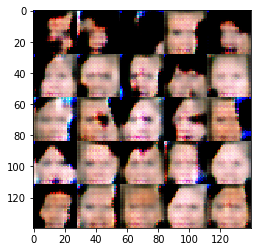

Epoch 1/1... Batch 510... Discriminator Loss: 0.9797... Generator Loss: 1.5688
Epoch 1/1... Batch 520... Discriminator Loss: 1.2821... Generator Loss: 1.4258
Epoch 1/1... Batch 530... Discriminator Loss: 1.1486... Generator Loss: 1.3527
Epoch 1/1... Batch 540... Discriminator Loss: 1.1750... Generator Loss: 0.9235
Epoch 1/1... Batch 550... Discriminator Loss: 1.1808... Generator Loss: 0.6537
Epoch 1/1... Batch 560... Discriminator Loss: 1.3537... Generator Loss: 0.5193
Epoch 1/1... Batch 570... Discriminator Loss: 1.0386... Generator Loss: 0.7787
Epoch 1/1... Batch 580... Discriminator Loss: 1.1071... Generator Loss: 0.9310
Epoch 1/1... Batch 590... Discriminator Loss: 0.8648... Generator Loss: 2.0783
Epoch 1/1... Batch 600... Discriminator Loss: 1.1035... Generator Loss: 0.7130


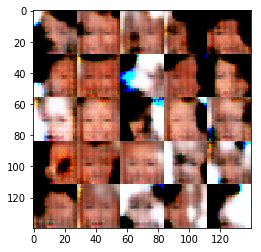

Epoch 1/1... Batch 610... Discriminator Loss: 0.9236... Generator Loss: 1.1944
Epoch 1/1... Batch 620... Discriminator Loss: 1.0500... Generator Loss: 1.0287
Epoch 1/1... Batch 630... Discriminator Loss: 1.5794... Generator Loss: 3.2102
Epoch 1/1... Batch 640... Discriminator Loss: 1.6137... Generator Loss: 0.3766
Epoch 1/1... Batch 650... Discriminator Loss: 0.8994... Generator Loss: 1.0462
Epoch 1/1... Batch 660... Discriminator Loss: 0.7427... Generator Loss: 1.3980
Epoch 1/1... Batch 670... Discriminator Loss: 0.9174... Generator Loss: 0.9312
Epoch 1/1... Batch 680... Discriminator Loss: 1.6220... Generator Loss: 0.3721
Epoch 1/1... Batch 690... Discriminator Loss: 1.4780... Generator Loss: 1.0991
Epoch 1/1... Batch 700... Discriminator Loss: 0.4914... Generator Loss: 4.1711


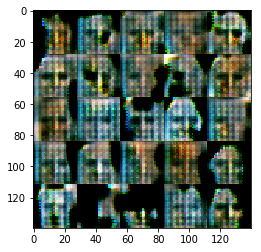

Epoch 1/1... Batch 710... Discriminator Loss: 1.7912... Generator Loss: 4.7297
Epoch 1/1... Batch 720... Discriminator Loss: 2.0537... Generator Loss: 4.5426
Epoch 1/1... Batch 730... Discriminator Loss: 1.5152... Generator Loss: 0.5109
Epoch 1/1... Batch 740... Discriminator Loss: 1.0898... Generator Loss: 0.9362
Epoch 1/1... Batch 750... Discriminator Loss: 1.2900... Generator Loss: 0.6852
Epoch 1/1... Batch 760... Discriminator Loss: 1.0919... Generator Loss: 1.0899
Epoch 1/1... Batch 770... Discriminator Loss: 1.0820... Generator Loss: 0.9108
Epoch 1/1... Batch 780... Discriminator Loss: 1.1781... Generator Loss: 0.8310
Epoch 1/1... Batch 790... Discriminator Loss: 0.8359... Generator Loss: 1.4456
Epoch 1/1... Batch 800... Discriminator Loss: 1.4574... Generator Loss: 0.6039


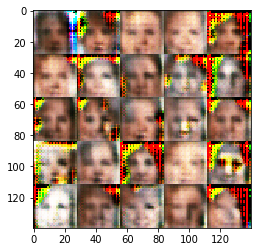

Epoch 1/1... Batch 810... Discriminator Loss: 1.1687... Generator Loss: 1.2196
Epoch 1/1... Batch 820... Discriminator Loss: 1.6634... Generator Loss: 0.5891
Epoch 1/1... Batch 830... Discriminator Loss: 0.6780... Generator Loss: 2.2792
Epoch 1/1... Batch 840... Discriminator Loss: 0.4084... Generator Loss: 3.3130
Epoch 1/1... Batch 850... Discriminator Loss: 1.1850... Generator Loss: 0.7073
Epoch 1/1... Batch 860... Discriminator Loss: 0.9299... Generator Loss: 1.2106
Epoch 1/1... Batch 870... Discriminator Loss: 0.8511... Generator Loss: 1.0468
Epoch 1/1... Batch 880... Discriminator Loss: 0.8536... Generator Loss: 1.0681
Epoch 1/1... Batch 890... Discriminator Loss: 2.1075... Generator Loss: 0.2804
Epoch 1/1... Batch 900... Discriminator Loss: 0.9861... Generator Loss: 1.1668


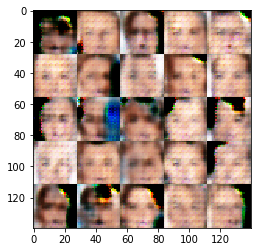

Epoch 1/1... Batch 910... Discriminator Loss: 1.4484... Generator Loss: 0.5955
Epoch 1/1... Batch 920... Discriminator Loss: 1.2090... Generator Loss: 1.0790
Epoch 1/1... Batch 930... Discriminator Loss: 1.0840... Generator Loss: 0.7749
Epoch 1/1... Batch 940... Discriminator Loss: 0.9327... Generator Loss: 1.6255
Epoch 1/1... Batch 950... Discriminator Loss: 1.1308... Generator Loss: 1.1471
Epoch 1/1... Batch 960... Discriminator Loss: 1.0864... Generator Loss: 1.1152
Epoch 1/1... Batch 970... Discriminator Loss: 0.9741... Generator Loss: 1.6043
Epoch 1/1... Batch 980... Discriminator Loss: 1.4569... Generator Loss: 1.0704
Epoch 1/1... Batch 990... Discriminator Loss: 1.3686... Generator Loss: 0.7204
Epoch 1/1... Batch 1000... Discriminator Loss: 1.3298... Generator Loss: 0.7682


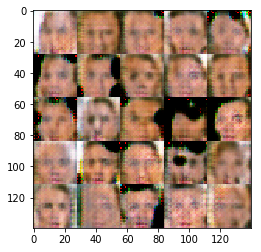

Epoch 1/1... Batch 1010... Discriminator Loss: 0.9631... Generator Loss: 1.5632
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2473... Generator Loss: 0.5703
Epoch 1/1... Batch 1030... Discriminator Loss: 0.6614... Generator Loss: 1.4673
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4793... Generator Loss: 1.2682
Epoch 1/1... Batch 1050... Discriminator Loss: 1.0059... Generator Loss: 1.1428
Epoch 1/1... Batch 1060... Discriminator Loss: 1.1957... Generator Loss: 0.8526
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2550... Generator Loss: 1.1537
Epoch 1/1... Batch 1080... Discriminator Loss: 1.1936... Generator Loss: 1.0249
Epoch 1/1... Batch 1090... Discriminator Loss: 0.9083... Generator Loss: 1.0535
Epoch 1/1... Batch 1100... Discriminator Loss: 1.0489... Generator Loss: 1.2340


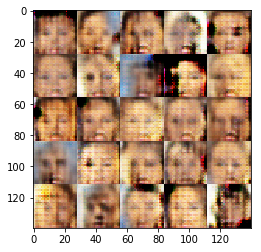

Epoch 1/1... Batch 1110... Discriminator Loss: 0.9112... Generator Loss: 0.9544
Epoch 1/1... Batch 1120... Discriminator Loss: 1.2208... Generator Loss: 0.9631
Epoch 1/1... Batch 1130... Discriminator Loss: 1.3870... Generator Loss: 1.3948
Epoch 1/1... Batch 1140... Discriminator Loss: 1.2491... Generator Loss: 3.7643
Epoch 1/1... Batch 1150... Discriminator Loss: 1.7131... Generator Loss: 0.3623
Epoch 1/1... Batch 1160... Discriminator Loss: 0.9111... Generator Loss: 0.9944
Epoch 1/1... Batch 1170... Discriminator Loss: 1.1183... Generator Loss: 1.7039
Epoch 1/1... Batch 1180... Discriminator Loss: 1.5679... Generator Loss: 1.2275
Epoch 1/1... Batch 1190... Discriminator Loss: 3.4651... Generator Loss: 4.1707
Epoch 1/1... Batch 1200... Discriminator Loss: 1.1153... Generator Loss: 0.9814


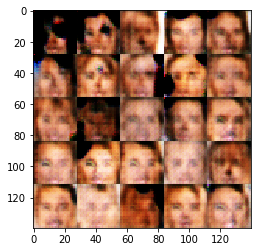

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2875... Generator Loss: 0.5684
Epoch 1/1... Batch 1220... Discriminator Loss: 0.8010... Generator Loss: 1.6331
Epoch 1/1... Batch 1230... Discriminator Loss: 1.0222... Generator Loss: 1.3415
Epoch 1/1... Batch 1240... Discriminator Loss: 1.3043... Generator Loss: 0.6275
Epoch 1/1... Batch 1250... Discriminator Loss: 1.8806... Generator Loss: 0.3179
Epoch 1/1... Batch 1260... Discriminator Loss: 0.8272... Generator Loss: 1.2893
Epoch 1/1... Batch 1270... Discriminator Loss: 1.0061... Generator Loss: 0.8416
Epoch 1/1... Batch 1280... Discriminator Loss: 0.9734... Generator Loss: 0.9240
Epoch 1/1... Batch 1290... Discriminator Loss: 1.0293... Generator Loss: 0.9441
Epoch 1/1... Batch 1300... Discriminator Loss: 1.1669... Generator Loss: 1.0583


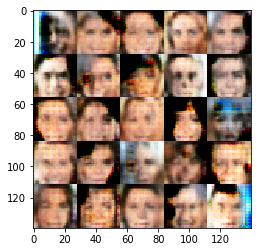

Epoch 1/1... Batch 1310... Discriminator Loss: 1.1747... Generator Loss: 0.7647
Epoch 1/1... Batch 1320... Discriminator Loss: 1.1504... Generator Loss: 1.1847
Epoch 1/1... Batch 1330... Discriminator Loss: 1.4508... Generator Loss: 0.5461
Epoch 1/1... Batch 1340... Discriminator Loss: 1.1761... Generator Loss: 1.0150
Epoch 1/1... Batch 1350... Discriminator Loss: 1.4015... Generator Loss: 0.8664
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2366... Generator Loss: 1.0391
Epoch 1/1... Batch 1370... Discriminator Loss: 1.2528... Generator Loss: 1.4052
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2406... Generator Loss: 1.0517
Epoch 1/1... Batch 1390... Discriminator Loss: 1.4265... Generator Loss: 0.5846
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1555... Generator Loss: 1.1553


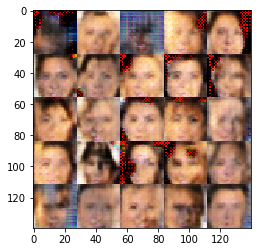

Epoch 1/1... Batch 1410... Discriminator Loss: 1.5928... Generator Loss: 1.6750
Epoch 1/1... Batch 1420... Discriminator Loss: 1.3723... Generator Loss: 0.8513
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1636... Generator Loss: 1.1929
Epoch 1/1... Batch 1440... Discriminator Loss: 1.5301... Generator Loss: 0.9759
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3029... Generator Loss: 0.8335
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2036... Generator Loss: 1.5917
Epoch 1/1... Batch 1470... Discriminator Loss: 1.0832... Generator Loss: 0.7462
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3033... Generator Loss: 0.7790
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3494... Generator Loss: 0.9062
Epoch 1/1... Batch 1500... Discriminator Loss: 1.3171... Generator Loss: 0.5565


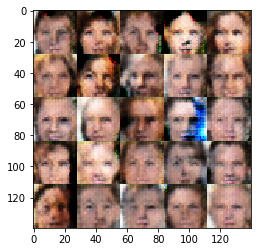

Epoch 1/1... Batch 1510... Discriminator Loss: 1.4857... Generator Loss: 0.5279
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3010... Generator Loss: 1.5027
Epoch 1/1... Batch 1530... Discriminator Loss: 0.7635... Generator Loss: 1.2332
Epoch 1/1... Batch 1540... Discriminator Loss: 1.4455... Generator Loss: 1.2749
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4143... Generator Loss: 0.9912
Epoch 1/1... Batch 1560... Discriminator Loss: 1.1038... Generator Loss: 1.0092
Epoch 1/1... Batch 1570... Discriminator Loss: 1.3901... Generator Loss: 0.7458
Epoch 1/1... Batch 1580... Discriminator Loss: 1.3103... Generator Loss: 0.7721
Epoch 1/1... Batch 1590... Discriminator Loss: 1.5705... Generator Loss: 0.4419
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3658... Generator Loss: 0.4929


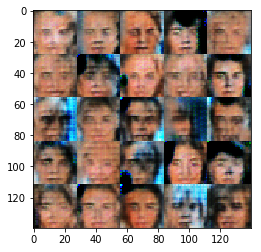

Epoch 1/1... Batch 1610... Discriminator Loss: 0.4429... Generator Loss: 3.1977
Epoch 1/1... Batch 1620... Discriminator Loss: 1.1498... Generator Loss: 1.3797
Epoch 1/1... Batch 1630... Discriminator Loss: 1.1412... Generator Loss: 0.7679
Epoch 1/1... Batch 1640... Discriminator Loss: 1.0373... Generator Loss: 1.3293
Epoch 1/1... Batch 1650... Discriminator Loss: 0.8883... Generator Loss: 1.1159
Epoch 1/1... Batch 1660... Discriminator Loss: 1.5180... Generator Loss: 0.5248
Epoch 1/1... Batch 1670... Discriminator Loss: 1.5419... Generator Loss: 0.8736
Epoch 1/1... Batch 1680... Discriminator Loss: 1.1692... Generator Loss: 0.9982
Epoch 1/1... Batch 1690... Discriminator Loss: 0.8019... Generator Loss: 1.2645
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2560... Generator Loss: 1.0100


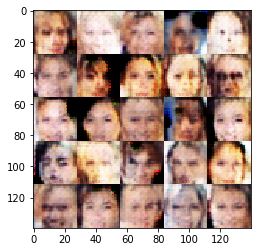

Epoch 1/1... Batch 1710... Discriminator Loss: 1.5626... Generator Loss: 2.2562
Epoch 1/1... Batch 1720... Discriminator Loss: 1.2768... Generator Loss: 0.9890
Epoch 1/1... Batch 1730... Discriminator Loss: 1.2033... Generator Loss: 0.8101
Epoch 1/1... Batch 1740... Discriminator Loss: 1.2418... Generator Loss: 1.7731
Epoch 1/1... Batch 1750... Discriminator Loss: 1.3458... Generator Loss: 0.7532
Epoch 1/1... Batch 1760... Discriminator Loss: 0.9650... Generator Loss: 1.0253
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3179... Generator Loss: 0.7779
Epoch 1/1... Batch 1780... Discriminator Loss: 1.0294... Generator Loss: 1.2502
Epoch 1/1... Batch 1790... Discriminator Loss: 1.5197... Generator Loss: 0.5416
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3506... Generator Loss: 0.6505


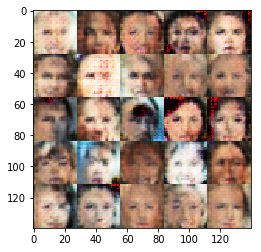

Epoch 1/1... Batch 1810... Discriminator Loss: 1.3248... Generator Loss: 0.7840
Epoch 1/1... Batch 1820... Discriminator Loss: 1.5601... Generator Loss: 1.0023
Epoch 1/1... Batch 1830... Discriminator Loss: 1.1823... Generator Loss: 0.9587
Epoch 1/1... Batch 1840... Discriminator Loss: 1.5049... Generator Loss: 0.5404
Epoch 1/1... Batch 1850... Discriminator Loss: 1.1119... Generator Loss: 0.7951
Epoch 1/1... Batch 1860... Discriminator Loss: 1.0297... Generator Loss: 1.5189
Epoch 1/1... Batch 1870... Discriminator Loss: 1.1143... Generator Loss: 0.7089
Epoch 1/1... Batch 1880... Discriminator Loss: 1.1096... Generator Loss: 0.8085
Epoch 1/1... Batch 1890... Discriminator Loss: 1.1525... Generator Loss: 1.1029
Epoch 1/1... Batch 1900... Discriminator Loss: 1.5201... Generator Loss: 1.2570


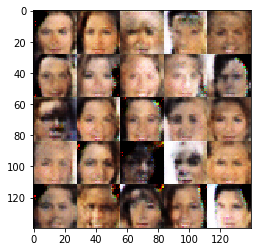

Epoch 1/1... Batch 1910... Discriminator Loss: 1.5667... Generator Loss: 0.4916
Epoch 1/1... Batch 1920... Discriminator Loss: 1.2474... Generator Loss: 0.7844
Epoch 1/1... Batch 1930... Discriminator Loss: 1.2200... Generator Loss: 1.2966
Epoch 1/1... Batch 1940... Discriminator Loss: 1.1392... Generator Loss: 0.7111
Epoch 1/1... Batch 1950... Discriminator Loss: 1.3965... Generator Loss: 0.6258
Epoch 1/1... Batch 1960... Discriminator Loss: 1.3951... Generator Loss: 0.7744
Epoch 1/1... Batch 1970... Discriminator Loss: 1.1340... Generator Loss: 0.7277
Epoch 1/1... Batch 1980... Discriminator Loss: 0.9529... Generator Loss: 0.9783
Epoch 1/1... Batch 1990... Discriminator Loss: 1.5925... Generator Loss: 0.6321
Epoch 1/1... Batch 2000... Discriminator Loss: 1.0903... Generator Loss: 1.1259


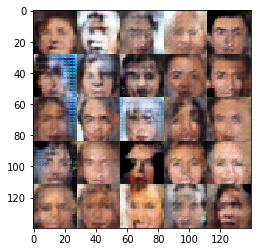

Epoch 1/1... Batch 2010... Discriminator Loss: 0.9370... Generator Loss: 0.9321
Epoch 1/1... Batch 2020... Discriminator Loss: 1.3467... Generator Loss: 0.8482
Epoch 1/1... Batch 2030... Discriminator Loss: 1.3511... Generator Loss: 0.6863
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1666... Generator Loss: 1.1955
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3468... Generator Loss: 0.9270
Epoch 1/1... Batch 2060... Discriminator Loss: 1.0980... Generator Loss: 0.8723
Epoch 1/1... Batch 2070... Discriminator Loss: 1.5568... Generator Loss: 0.5868
Epoch 1/1... Batch 2080... Discriminator Loss: 1.3471... Generator Loss: 0.8960
Epoch 1/1... Batch 2090... Discriminator Loss: 1.2800... Generator Loss: 0.9041
Epoch 1/1... Batch 2100... Discriminator Loss: 1.2110... Generator Loss: 1.1467


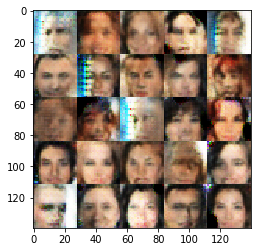

Epoch 1/1... Batch 2110... Discriminator Loss: 1.0991... Generator Loss: 0.8396
Epoch 1/1... Batch 2120... Discriminator Loss: 1.1859... Generator Loss: 0.8571
Epoch 1/1... Batch 2130... Discriminator Loss: 1.0080... Generator Loss: 0.8552
Epoch 1/1... Batch 2140... Discriminator Loss: 1.2053... Generator Loss: 1.0146
Epoch 1/1... Batch 2150... Discriminator Loss: 1.0793... Generator Loss: 1.0169
Epoch 1/1... Batch 2160... Discriminator Loss: 1.3333... Generator Loss: 1.1071
Epoch 1/1... Batch 2170... Discriminator Loss: 1.1885... Generator Loss: 1.0187
Epoch 1/1... Batch 2180... Discriminator Loss: 1.5209... Generator Loss: 0.4682
Epoch 1/1... Batch 2190... Discriminator Loss: 1.0925... Generator Loss: 0.8618
Epoch 1/1... Batch 2200... Discriminator Loss: 1.1434... Generator Loss: 1.2067


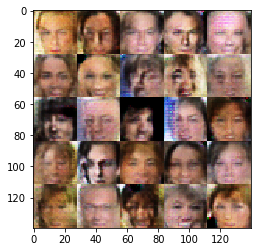

Epoch 1/1... Batch 2210... Discriminator Loss: 1.1431... Generator Loss: 0.7763
Epoch 1/1... Batch 2220... Discriminator Loss: 1.2351... Generator Loss: 0.8443
Epoch 1/1... Batch 2230... Discriminator Loss: 1.2839... Generator Loss: 0.9395
Epoch 1/1... Batch 2240... Discriminator Loss: 1.0761... Generator Loss: 1.2201
Epoch 1/1... Batch 2250... Discriminator Loss: 1.1046... Generator Loss: 0.7222
Epoch 1/1... Batch 2260... Discriminator Loss: 1.3848... Generator Loss: 0.6635
Epoch 1/1... Batch 2270... Discriminator Loss: 1.1385... Generator Loss: 0.9877
Epoch 1/1... Batch 2280... Discriminator Loss: 1.3643... Generator Loss: 0.7918
Epoch 1/1... Batch 2290... Discriminator Loss: 1.1091... Generator Loss: 0.9608
Epoch 1/1... Batch 2300... Discriminator Loss: 1.1817... Generator Loss: 0.7306


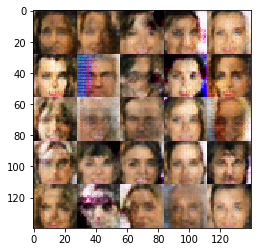

Epoch 1/1... Batch 2310... Discriminator Loss: 1.2234... Generator Loss: 0.7033
Epoch 1/1... Batch 2320... Discriminator Loss: 1.4250... Generator Loss: 0.5987
Epoch 1/1... Batch 2330... Discriminator Loss: 1.2367... Generator Loss: 0.9508
Epoch 1/1... Batch 2340... Discriminator Loss: 1.0545... Generator Loss: 0.9267
Epoch 1/1... Batch 2350... Discriminator Loss: 1.1998... Generator Loss: 0.8818
Epoch 1/1... Batch 2360... Discriminator Loss: 1.1731... Generator Loss: 0.7989
Epoch 1/1... Batch 2370... Discriminator Loss: 1.3011... Generator Loss: 0.5863
Epoch 1/1... Batch 2380... Discriminator Loss: 1.0001... Generator Loss: 1.3298
Epoch 1/1... Batch 2390... Discriminator Loss: 1.3260... Generator Loss: 1.5213
Epoch 1/1... Batch 2400... Discriminator Loss: 0.9201... Generator Loss: 1.5560


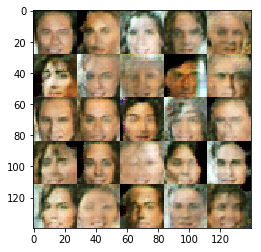

Epoch 1/1... Batch 2410... Discriminator Loss: 1.4174... Generator Loss: 0.6282
Epoch 1/1... Batch 2420... Discriminator Loss: 1.1400... Generator Loss: 1.0150
Epoch 1/1... Batch 2430... Discriminator Loss: 0.9197... Generator Loss: 1.0838
Epoch 1/1... Batch 2440... Discriminator Loss: 0.6782... Generator Loss: 1.4741
Epoch 1/1... Batch 2450... Discriminator Loss: 1.5974... Generator Loss: 0.5582
Epoch 1/1... Batch 2460... Discriminator Loss: 1.2344... Generator Loss: 1.4141
Epoch 1/1... Batch 2470... Discriminator Loss: 1.0182... Generator Loss: 1.0669
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1516... Generator Loss: 1.3869
Epoch 1/1... Batch 2490... Discriminator Loss: 0.9353... Generator Loss: 1.3771
Epoch 1/1... Batch 2500... Discriminator Loss: 1.1169... Generator Loss: 1.0584


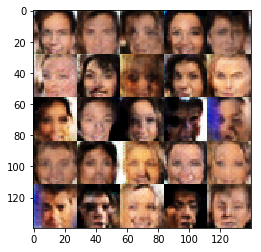

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1493... Generator Loss: 0.7969
Epoch 1/1... Batch 2520... Discriminator Loss: 1.3071... Generator Loss: 0.7248
Epoch 1/1... Batch 2530... Discriminator Loss: 1.5921... Generator Loss: 0.5702
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1359... Generator Loss: 0.8030
Epoch 1/1... Batch 2550... Discriminator Loss: 1.1578... Generator Loss: 1.3448
Epoch 1/1... Batch 2560... Discriminator Loss: 1.5075... Generator Loss: 1.4804
Epoch 1/1... Batch 2570... Discriminator Loss: 1.4280... Generator Loss: 0.8432
Epoch 1/1... Batch 2580... Discriminator Loss: 1.0768... Generator Loss: 0.9887
Epoch 1/1... Batch 2590... Discriminator Loss: 1.0661... Generator Loss: 1.2229
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2906... Generator Loss: 0.8542


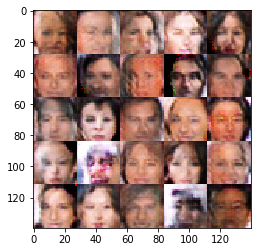

Epoch 1/1... Batch 2610... Discriminator Loss: 0.9514... Generator Loss: 1.0325
Epoch 1/1... Batch 2620... Discriminator Loss: 1.1159... Generator Loss: 1.0897
Epoch 1/1... Batch 2630... Discriminator Loss: 0.9693... Generator Loss: 1.5417
Epoch 1/1... Batch 2640... Discriminator Loss: 1.3051... Generator Loss: 0.6112
Epoch 1/1... Batch 2650... Discriminator Loss: 1.1779... Generator Loss: 0.6875
Epoch 1/1... Batch 2660... Discriminator Loss: 1.3658... Generator Loss: 0.7855
Epoch 1/1... Batch 2670... Discriminator Loss: 0.9123... Generator Loss: 1.0927
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1366... Generator Loss: 0.8095
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2091... Generator Loss: 0.6430
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3301... Generator Loss: 0.6943


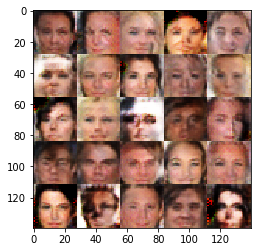

Epoch 1/1... Batch 2710... Discriminator Loss: 1.2524... Generator Loss: 0.8596
Epoch 1/1... Batch 2720... Discriminator Loss: 1.2843... Generator Loss: 0.8567
Epoch 1/1... Batch 2730... Discriminator Loss: 1.0066... Generator Loss: 0.8837
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2761... Generator Loss: 0.9778
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1095... Generator Loss: 1.0653
Epoch 1/1... Batch 2760... Discriminator Loss: 1.1466... Generator Loss: 0.7999
Epoch 1/1... Batch 2770... Discriminator Loss: 0.9457... Generator Loss: 1.9898
Epoch 1/1... Batch 2780... Discriminator Loss: 1.0592... Generator Loss: 0.9340
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1007... Generator Loss: 1.3896
Epoch 1/1... Batch 2800... Discriminator Loss: 0.8676... Generator Loss: 3.5173


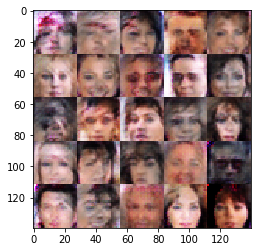

Epoch 1/1... Batch 2810... Discriminator Loss: 0.6116... Generator Loss: 1.8371
Epoch 1/1... Batch 2820... Discriminator Loss: 1.3391... Generator Loss: 0.7670
Epoch 1/1... Batch 2830... Discriminator Loss: 1.2368... Generator Loss: 0.7632
Epoch 1/1... Batch 2840... Discriminator Loss: 1.4150... Generator Loss: 0.6169
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2186... Generator Loss: 0.6769
Epoch 1/1... Batch 2860... Discriminator Loss: 1.1193... Generator Loss: 1.3165
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0752... Generator Loss: 1.0076
Epoch 1/1... Batch 2880... Discriminator Loss: 1.1995... Generator Loss: 1.7397
Epoch 1/1... Batch 2890... Discriminator Loss: 1.2166... Generator Loss: 1.1454
Epoch 1/1... Batch 2900... Discriminator Loss: 1.2158... Generator Loss: 0.7277


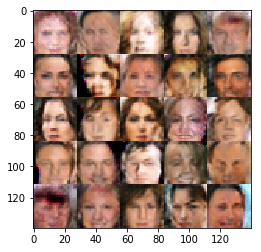

Epoch 1/1... Batch 2910... Discriminator Loss: 1.2091... Generator Loss: 0.7693
Epoch 1/1... Batch 2920... Discriminator Loss: 1.2488... Generator Loss: 0.8447
Epoch 1/1... Batch 2930... Discriminator Loss: 1.1220... Generator Loss: 0.8969
Epoch 1/1... Batch 2940... Discriminator Loss: 1.4548... Generator Loss: 0.7354
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2131... Generator Loss: 0.7291
Epoch 1/1... Batch 2960... Discriminator Loss: 1.2022... Generator Loss: 1.0344
Epoch 1/1... Batch 2970... Discriminator Loss: 1.0891... Generator Loss: 1.0777
Epoch 1/1... Batch 2980... Discriminator Loss: 2.1347... Generator Loss: 0.2519
Epoch 1/1... Batch 2990... Discriminator Loss: 1.3401... Generator Loss: 0.9788
Epoch 1/1... Batch 3000... Discriminator Loss: 1.0430... Generator Loss: 0.9036


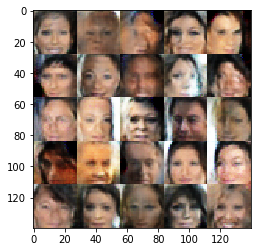

Epoch 1/1... Batch 3010... Discriminator Loss: 1.1241... Generator Loss: 0.7806
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2976... Generator Loss: 1.8084
Epoch 1/1... Batch 3030... Discriminator Loss: 1.2048... Generator Loss: 0.7961
Epoch 1/1... Batch 3040... Discriminator Loss: 0.8632... Generator Loss: 1.1741
Epoch 1/1... Batch 3050... Discriminator Loss: 1.2492... Generator Loss: 0.7234
Epoch 1/1... Batch 3060... Discriminator Loss: 1.1192... Generator Loss: 0.9959
Epoch 1/1... Batch 3070... Discriminator Loss: 1.1515... Generator Loss: 0.8734
Epoch 1/1... Batch 3080... Discriminator Loss: 1.2212... Generator Loss: 0.9101
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1648... Generator Loss: 0.6470
Epoch 1/1... Batch 3100... Discriminator Loss: 1.1633... Generator Loss: 0.8905


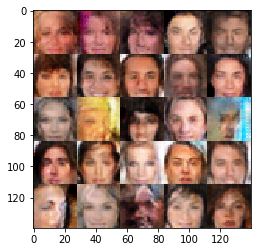

Epoch 1/1... Batch 3110... Discriminator Loss: 1.2282... Generator Loss: 1.2654
Epoch 1/1... Batch 3120... Discriminator Loss: 1.6230... Generator Loss: 0.5437
Epoch 1/1... Batch 3130... Discriminator Loss: 1.4058... Generator Loss: 0.8505
Epoch 1/1... Batch 3140... Discriminator Loss: 1.1155... Generator Loss: 0.8259
Epoch 1/1... Batch 3150... Discriminator Loss: 1.4906... Generator Loss: 0.6898
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2894... Generator Loss: 0.6933


In [17]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.